In [144]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from typing import Dict

import warnings
warnings.filterwarnings("ignore")

In [145]:
seed_value = 36

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [146]:
from src.preprocessing import prepare_data, get_traintest
from src.processing import Predictor
from src.models.UTS_models import EntropySensor
from src.visualization import plot_result

In [147]:
model_store_path = './saved_models/'

In [148]:
pd.set_option('display.max_rows', 200)

# Загрузка данных

### Загрузка из подготовленных CSV

In [149]:
path = './data/Dec2019.csv'
df = pd.read_csv(path, parse_dates=True, index_col=[0])
df.replace({'Active': 1, 'Inactive': 0}, inplace=True)

In [150]:
df_train = df.loc[:'2019-12-06 12:30:00'].copy()
df_train.head(3)

,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,AIT202.Pv,...,FIT601.Pv,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm
t_stamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 10:05:00,3.0,658.661255,0.0,1.0,2.0,1.0,2.0,2.313523,35.21533,8.205781,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
2019-12-06 10:05:01,3.0,659.171600,0.0,1.0,2.0,1.0,2.0,2.311857,35.21533,8.205781,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1
2019-12-06 10:05:02,3.0,659.681800,0.0,1.0,2.0,1.0,2.0,2.311601,35.21533,8.208344,...,0.000256,2.0,1.0,1.0,0,0,1,0,0,1


In [151]:
df_test = df.loc['2019-12-06 12:30:00':]

anomaly_idxs = [['2019-12-06 12:30:55', '2019-12-06 12:33:55'],
                ['2019-12-06 12:43:55', '2019-12-06 12:46:55'],
                ['2019-12-06 12:56:55', '2019-12-06 12:59:55'], 
                ['2019-12-06 13:09:55', '2019-12-06 13:12:55'], 
                ['2019-12-06 13:22:55', '2019-12-06 13:25:55']]

df_test['anomaly'] = 0

for idx in anomaly_idxs:
    df_test['anomaly'].loc[idx[0]:idx[1]] = 1

df_test.head(3)

,P1_STATE,LIT101.Pv,FIT101.Pv,MV101.Status,P101.Status,P102.Status,P2_STATE,FIT201.Pv,AIT201.Pv,AIT202.Pv,...,P601.Status,P602.Status,P603.Status,LSH601.Alarm,LSL601.Alarm,LSH602.Alarm,LSL602.Alarm,LSH603.Alarm,LSL603.Alarm,anomaly
t_stamp,,,,,,,,,,,,,,,,,,,,,
2019-12-06 12:30:00,2.0,781.836400,0.0,1.0,2.0,1.0,2.0,2.334924,37.330174,8.006153,...,1.0,1.0,1.0,0,0,1,0,0,1,0
2019-12-06 12:30:01,2.0,781.404663,0.0,1.0,2.0,1.0,2.0,2.333259,37.330174,8.006153,...,1.0,1.0,1.0,0,0,1,0,0,1,0
2019-12-06 12:30:02,2.0,781.090637,0.0,1.0,2.0,1.0,2.0,2.331593,37.330174,8.006153,...,1.0,1.0,1.0,0,0,1,0,0,1,0


In [152]:
summary = {}

## Подготовка train/test

In [153]:
window_size = 20

x_train, x_test, y_test = get_traintest(df_train[['FIT101.Pv']].copy(), 
                                        df_test[['FIT101.Pv','anomaly']].copy(), 
                                        window_size=window_size)

Scaling... (Standard)
Количество аномалий: 20.1%

Counter({0: 3596, 1: 905})
Create sequences with window size 20...
Размеры выборок:
            x_train: (8682, 20, 1)
            x_test: (4482, 20, 1)
            y_test: (4482, 20)


## Анализ энтропии

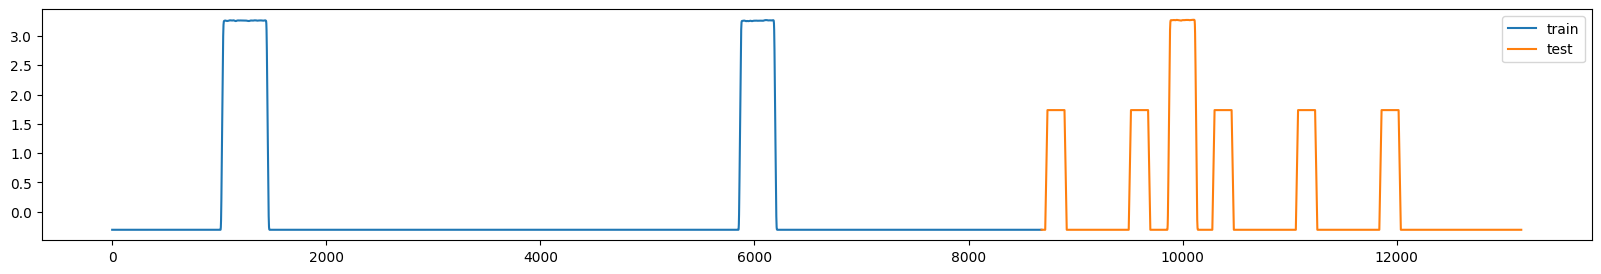

In [154]:
test_len, train_len = len(x_test), len(x_train)

plt.figure(figsize=(20,3))
plt.plot(range(train_len), np.mean(x_train, axis=1), label='train')
plt.plot(range(train_len, train_len+test_len), np.mean(x_test, axis=1), label='test')
plt.legend()
plt.show()

2022-09-21 13:06:25.267782: can't find saved model, fit model...


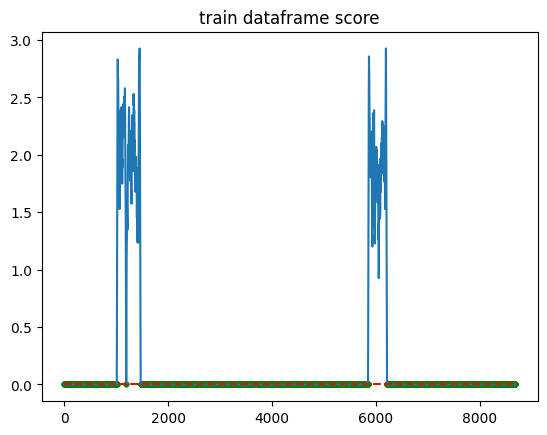

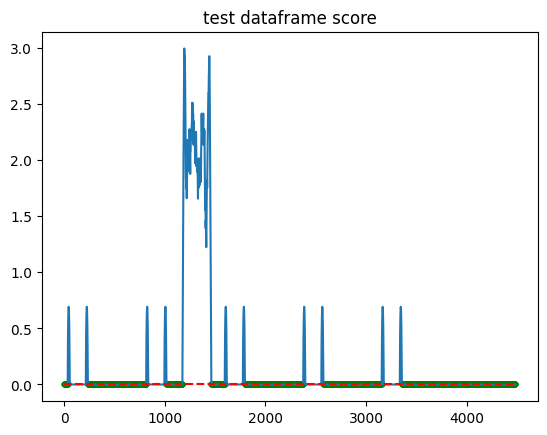

SWAT_Dec19_UTS_entropy
f1_score: 0.94
accuracy_score: 0.98
precision_score: 1.00
recall_score: 0.89


In [155]:
description='SWAT_Dec19_UTS_entropy'

model = EntropySensor()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description, window_size=window_size)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

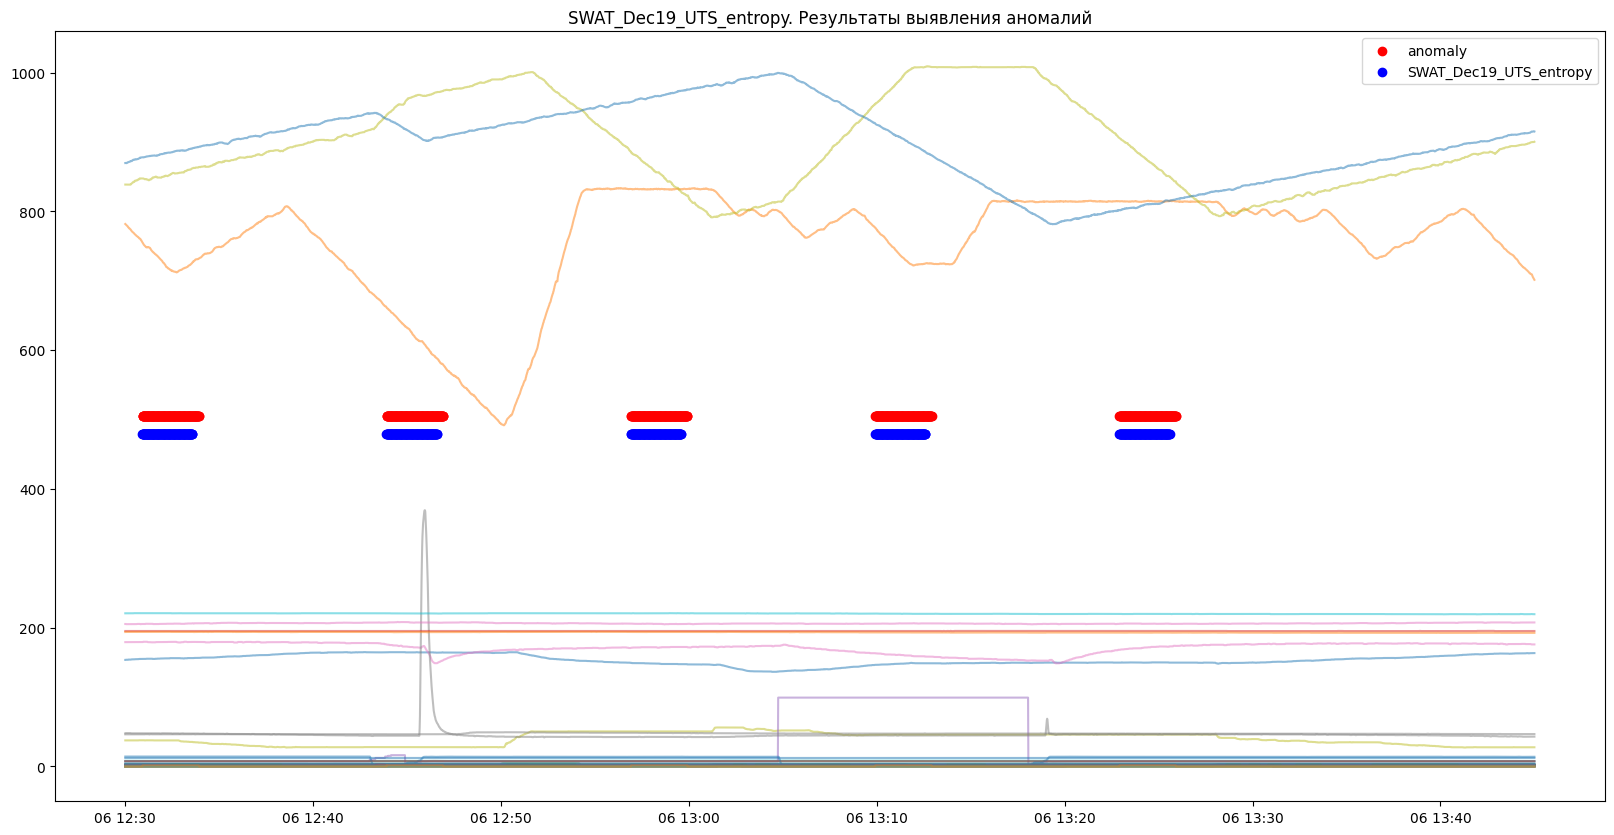

In [156]:
plot_result(df_test, y_test[:,0], y_pred, descr=description)

## Вывод
Расчет энтропии позволяет с высокой точностью определить факт подмены одной непрерывной величины на статичное значение

# Проверка на pcap

In [157]:
import pickle, struct

In [158]:
def convert_bytes_struct(string_hex):
    
    try:
        return struct.unpack('<f', bytes.fromhex(str(string_hex)))[0]
            
    except Exception as err:
        print(err, string_hex)
        return None

In [159]:
with open('./data/Dec2019_HMI_FIT_401_00002040_dataframe_v2.pkl', 'rb') as f:
    data = pickle.load(f)

In [160]:
data['hex'][0]

'a002e1e28a64ae3f000000000000000000004040000000400000803f0000003fa473be43000000008a64ae3f04000000'

In [161]:
for i in range(0, len(data['hex'][0])//8):
    data[f'byte_{i}'] = data['hex'].apply(lambda x: x[i*8:(i+1)*8])

In [162]:
data

,time,data,hex,byte_0,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11
0,1.575607e+09,b'\xa0\x02\xe1\xe2\x8ad\xae?\x00\x00\x00\x00\x...,a002e1e28a64ae3f000000000000000000004040000000...,a002e1e2,8a64ae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,a473be43,00000000,8a64ae3f,04000000
1,1.575607e+09,b'\xa0\x02\xe1\xe2\x8ad\xae?\x00\x00\x00\x00\x...,a002e1e28a64ae3f000000000000000000004040000000...,a002e1e2,8a64ae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,a473be43,00000000,8a64ae3f,04000000
2,1.575607e+09,b'\xa0\x02\xe1\xe2\x8ad\xae?\x00\x00\x00\x00\x...,a002e1e28a64ae3f000000000000000000004040000000...,a002e1e2,8a64ae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,a473be43,00000000,8a64ae3f,04000000
3,1.575607e+09,b'\xa0\x02\xe1\xe2\x8ad\xae?\x00\x00\x00\x00\x...,a002e1e28a64ae3f000000000000000000004040000000...,a002e1e2,8a64ae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,a473be43,00000000,8a64ae3f,04000000
4,1.575607e+09,b'\xa0\x02\xe1\xe2\x8ad\xae?\x00\x00\x00\x00\x...,a002e1e28a64ae3f000000000000000000004040000000...,a002e1e2,8a64ae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,a473be43,00000000,8a64ae3f,04000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42172,1.575607e+09,b'\xa0\x02\xe1\xe2\xcf\xea\xae?\x00\x00\x00\x0...,a002e1e2cfeaae3f000000000000000000004040000000...,a002e1e2,cfeaae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,fc9cbe43,00000000,cfeaae3f,04000000
42173,1.575607e+09,b'\xa0\x02\xe1\xe2\xcf\xea\xae?\x00\x00\x00\x0...,a002e1e2cfeaae3f000000000000000000004040000000...,a002e1e2,cfeaae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,fc9cbe43,00000000,cfeaae3f,04000000
42174,1.575607e+09,b'\xa0\x02\xe1\xe2\xcf\xea\xae?\x00\x00\x00\x0...,a002e1e2cfeaae3f000000000000000000004040000000...,a002e1e2,cfeaae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,fc9cbe43,00000000,cfeaae3f,04000000
42175,1.575607e+09,b'\xa0\x02\xe1\xe2\xcf\xea\xae?\x00\x00\x00\x0...,a002e1e2cfeaae3f000000000000000000004040000000...,a002e1e2,cfeaae3f,00000000,00000000,00004040,00000040,0000803f,0000003f,fc9cbe43,00000000,cfeaae3f,04000000


In [163]:
data_bytes = data.drop(['time','data','hex','byte_0'], axis=1).applymap(convert_bytes_struct)
data_bytes.index = pd.to_datetime(data['time'].astype(float), unit='s')

In [164]:
data_bytes.describe().T

,count,mean,std,min,25%,50%,75%,max
byte_1,42177.0,1.363773e+00,0.002443,1.355528e+00,1.362187e+00,1.363340e+00,1.365260e+00,1.371791e+00
byte_2,42177.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
byte_3,42177.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
byte_4,42177.0,3.000000e+00,0.000000,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
byte_5,42177.0,2.000000e+00,0.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
byte_6,42177.0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
byte_7,42177.0,5.000000e-01,0.000000,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
byte_8,42177.0,3.810649e+02,0.093403,3.809034e+02,3.809840e+02,3.810646e+02,3.811459e+02,3.812264e+02
byte_9,42177.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
byte_10,42177.0,1.363637e+00,0.002482,1.355528e+00,1.362187e+00,1.363340e+00,1.365260e+00,1.371791e+00


In [169]:
data_bytes['byte_1'].describe()

count    42177.000000
mean         1.363773
std          0.002443
min          1.355528
25%          1.362187
50%          1.363340
75%          1.365260
max          1.371791
Name: byte_1, dtype: float64

## Проверка гипотезы

In [170]:
df_train = data_bytes.iloc[:10000].copy()
df_train.head(3)

,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11
time,,,,,,,,,,,
2019-12-06 04:30:00.355334997,1.362443,0.0,0.0,3.0,2.0,1.0,0.5,380.903442,0.0,1.362443,5.605194e-45
2019-12-06 04:30:00.364401102,1.362443,0.0,0.0,3.0,2.0,1.0,0.5,380.903442,0.0,1.362443,5.605194e-45
2019-12-06 04:30:00.405678988,1.362443,0.0,0.0,3.0,2.0,1.0,0.5,380.903442,0.0,1.362443,5.605194e-45


In [180]:
df_test = data_bytes.iloc[10000:]


anomaly_idxs = [942,3198]

df_test['anomaly'] = 0

df_test['anomaly'].iloc[anomaly_idxs[0]:anomaly_idxs[1]] = 1

df_test.head(3)

,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,byte_9,byte_10,byte_11,anomaly
time,,,,,,,,,,,,
2019-12-06 04:33:30.252049923,1.365132,0.0,0.0,3.0,2.0,1.0,0.5,380.979614,0.0,1.365132,5.605194e-45,0
2019-12-06 04:33:30.292954922,1.364748,0.0,0.0,3.0,2.0,1.0,0.5,380.979614,0.0,1.364748,5.605194e-45,0
2019-12-06 04:33:30.292957067,1.364748,0.0,0.0,3.0,2.0,1.0,0.5,380.979614,0.0,1.364748,5.605194e-45,0


<AxesSubplot:xlabel='time'>

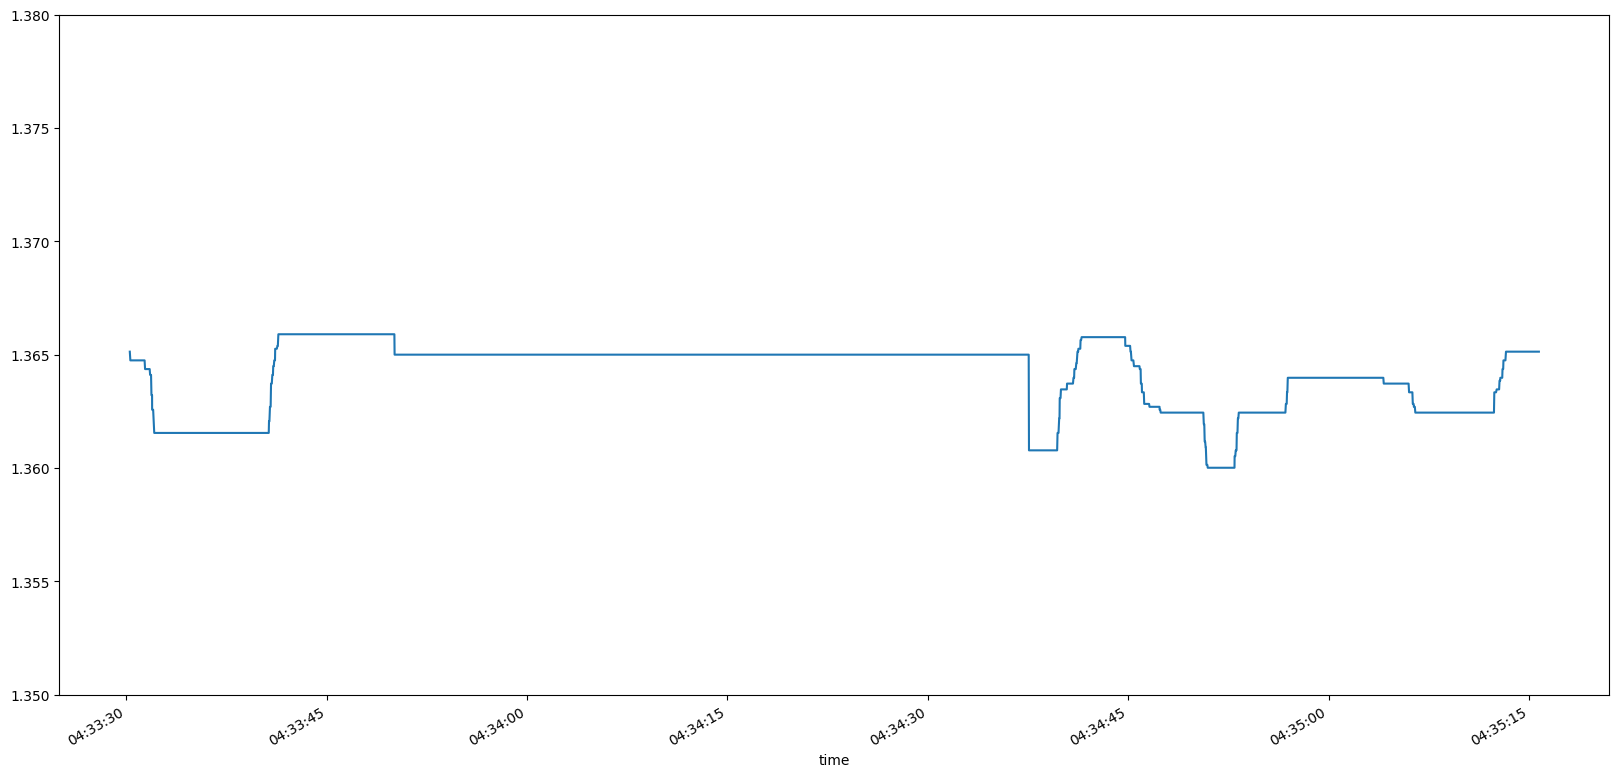

In [181]:
df_test['byte_1'][:5000].plot(figsize=(20,10), ylim=(1.35,1.38))
# anomaly_idx = df_test[df_test['anomaly']==1].index
# plt.scatter(anomaly_idx, [1.365]*len(anomaly_idx), c='r')

In [210]:
window_size = 600

x_train, x_test, y_test = get_traintest(df_train[['byte_1']].copy(), 
                                        df_test[['byte_1','anomaly']].copy(), 
                                        window_size=window_size)

Scaling... (Standard)
Количество аномалий: 7.0%

Counter({0: 29921, 1: 2256})
Create sequences with window size 600...
Размеры выборок:
            x_train: (9401, 600, 1)
            x_test: (31578, 600, 1)
            y_test: (31578, 600)


In [211]:
from math import log, e
import numpy as np
import matplotlib.pyplot as plt
import json

class EntropySensor:
    def __init__(self):
        self.model = {
                'static':set(), 
                'min': None, 
                'mean': None, 
                'max': None
                     }
        
    def fit(self, data, **kwargs):      
        H = []

        for i in range(0, data.shape[0]):
            h = self.get_entropy(data[i])

            H.append(h)
            
            if abs(h) == 0.:
                self.model['static'] |= set([np.mean(data[i])])
        
        self.model['min'] = np.min(H)
        self.model['mean'] = np.mean(H)
        self.model['max'] = np.max(H)
        self.model['static'] = list(self.model['static'])
        print(self.model['static'])
                
        return self.model
        
    def predict(self, data, **kwargs):
        H = []

        for i in range(0, data.shape[0]):
            h = self.get_entropy(data[i])
            H.append(h)
                    
        return H

    def get_anomalies(self, x_train, x_test, **kwargs):
        train_entropy = self.predict(x_train) 
        self.plot_score(x_train, train_entropy, title='train dataframe score')
        
        test_entropy = self.predict(x_test) 
        self.plot_score(x_test, test_entropy, title='test dataframe score')

        anomalies_predict = []

        for i, value in enumerate(test_entropy):
            
            if abs(value) == 0.:
                if  np.mean(x_test[i]) not in self.model['static']:
                    anomalies_predict.append(1)
                else:
                    anomalies_predict.append(0)
            
            else:
                anomalies_predict.append(0)

        return np.array(anomalies_predict)
    
    def get_entropy(self, data, base=None):
        value,counts = np.unique(data, return_counts=True)

        norm_counts = counts / counts.sum()
        base = e if base is None else base

        return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()
    
    def plot_score(self, data_value, data_H, title=''):   
        plt.plot(data_H)
        plt.hlines(0, 0, len(data_H), color='red', linestyle='--', zorder=10)
        
        for value in self.model['static']:       
            if value != None:        
                static_idxs = np.where(np.mean(data_value, axis=1)==value)[0]               
                if len(static_idxs) > 0:
                    plt.scatter(static_idxs, 
                                [data_H[i] for i in static_idxs], 
                                color='green', s=10)
                    
        plt.title(title)        
        plt.show()

    def save_model(self, path):  
        with open(f'{path}.txt', 'w') as f:
            json.dump(self.model, f)

    def load_model(self, path):
        with open(f'{path}.txt', 'r') as f:
            self.model = json.load(f'{path}.txt')

2022-09-21 13:51:13.797600: refit model...
[]


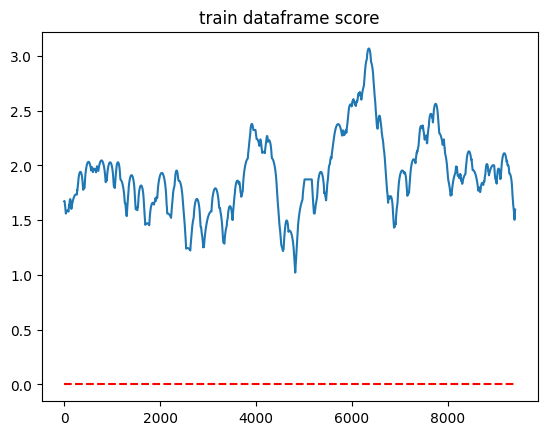

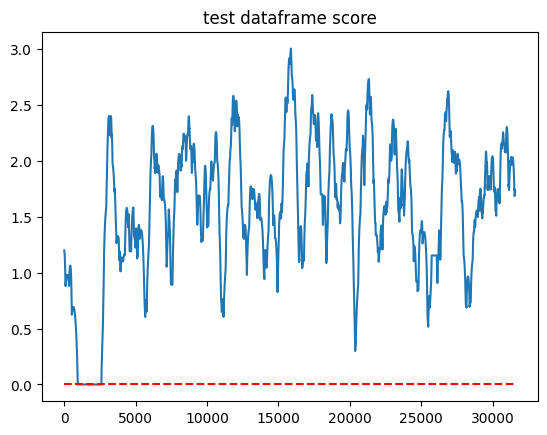

SWAT_Dec19_UTS_entropy_pcap
f1_score: 0.85
accuracy_score: 0.98
precision_score: 1.00
recall_score: 0.73


In [212]:
description='SWAT_Dec19_UTS_entropy_pcap'

model = EntropySensor()
predictor = Predictor(model, [x_train, x_test, y_test], descr=description, window_size=window_size, resave_model=True)
y_pred = predictor.get_anomalies()
summary[description] = predictor.get_score()

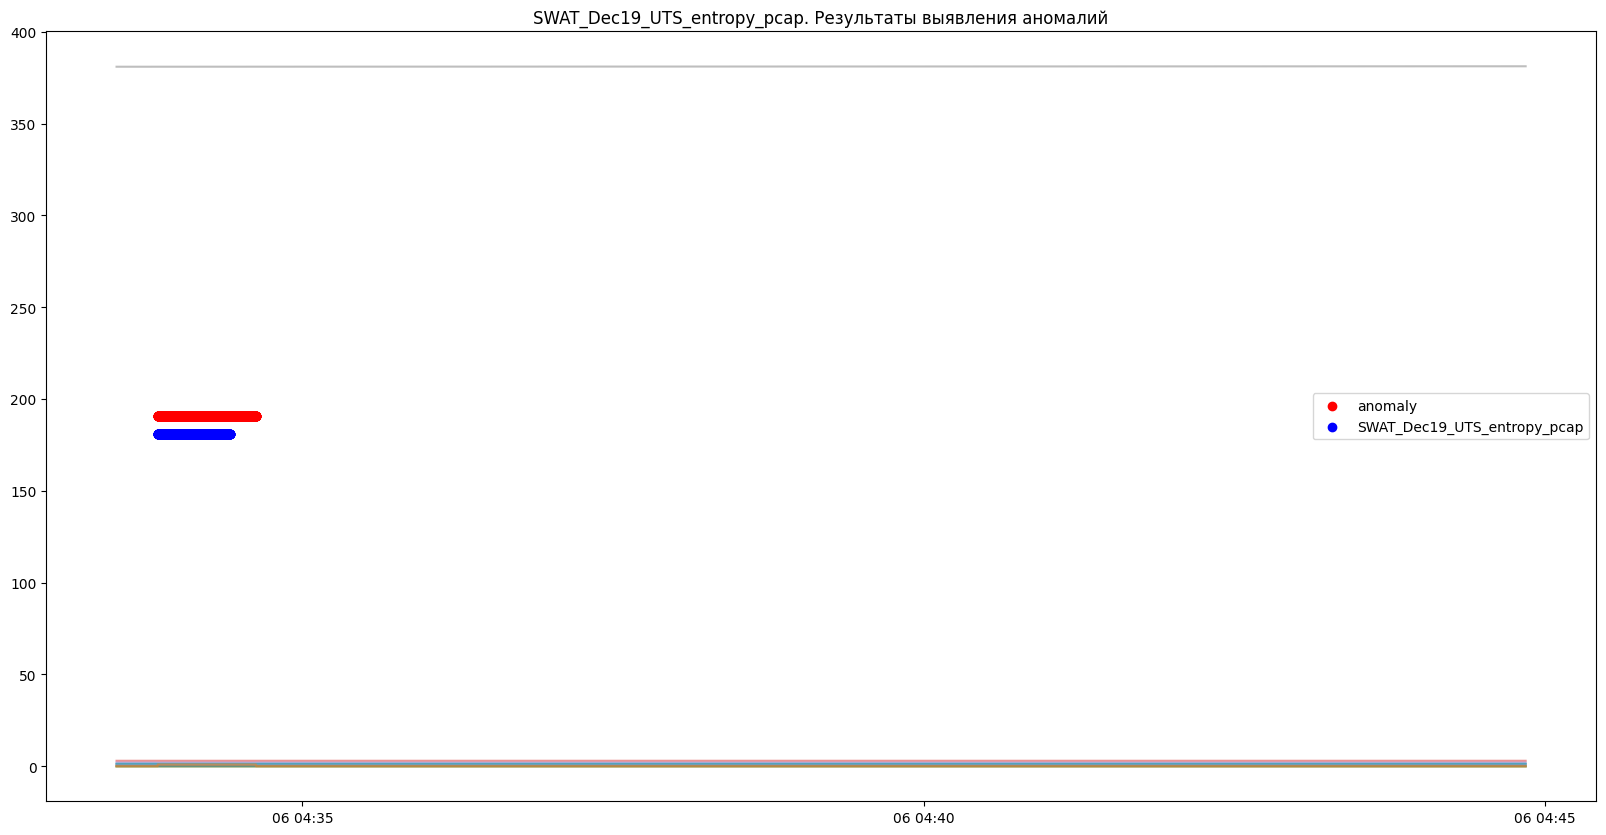

In [213]:
plot_result(df_test, y_test[:,0], y_pred, descr=description)